In [1]:
""" Load some libs """
""" python 2 lib using networkx """
import matplotlib.pyplot as plt
import networkx as nx
import random
import math
import pandas as pd
import statsmodels.api as sm
import glob
import os
import numpy as np
from PIL import Image
from helpers import *
import pickle
import time
#random.seed(100)
#tic = time.time()

/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
""" Let's see what WEPPS we have """
folders = sorted(glob.glob('WEPP_FILES/*'))
print folders


['WEPP_FILES/2004-Q4-DEC', 'WEPP_FILES/2007-Q4-DEC', 'WEPP_FILES/2014-q4-dec', 'WEPP_FILES/2015-Q1-MAR', 'WEPP_FILES/2015-Q2-JUN', 'WEPP_FILES/2015-Q4-DEC', 'WEPP_FILES/2015-q3-sep', 'WEPP_FILES/2016-Q1-APR', 'WEPP_FILES/2016-Q2-JUL', 'WEPP_FILES/2016-Q3-SEP', 'WEPP_FILES/2016-Q4-DEC', 'WEPP_FILES/2017-Q1-MAR', 'WEPP_FILES/2017-Q2-JUL', 'WEPP_FILES/2017-Q3-SEP', 'WEPP_FILES/2017-Q4-DEC']


In [3]:
"""Let's get a single WEPP db"""
chosen_db = folders[14]
#get the date as int
quarter_dict = {'Q1':0.0, 'Q2':0.25,'Q3':0.5,'Q4':0.75}
DATE = int(chosen_db.split('/')[1].split('-')[0])+quarter_dict[chosen_db.split('/')[1].split('-')[1].upper()]
print DATE


2017.75


In [4]:
""" let's load in our WEPP db"""
wepp_df = get_wepp(chosen_db)
print wepp_df

csv ALLUNITS
                              UNIT                     PLANT  \
0                 SLAVIC SALT IC 2               SLAVIC SALT   
1                          SLAVINO                   SLAVINO   
2              SLAVKOV U BRNA IC 1            SLAVKOV U BRNA   
3                SLAVONIA SOLAR PV            SLAVONIA SOLAR   
4                     SLAVONIJA CC                 SLAVONIJA   
5       SLAVONSKI BROD CRODUX GT 1     SLAVONSKI BROD CRODUX   
6       SLAVONSKI BROD CRODUX SC 1     SLAVONSKI BROD CRODUX   
7              SLAVONSKI BROD GT 1            SLAVONSKI BROD   
8                        SLAVOVA 1                   SLAVOVA   
9                      SLAVYANSK 1                 SLAVYANSK   
10                     SLAVYANSK 2                 SLAVYANSK   
11                     SLAVYANSK 3                 SLAVYANSK   
12                     SLAVYANSK 4                 SLAVYANSK   
13                     SLAVYANSK 5                 SLAVYANSK   
14                     SLAV

In [5]:
""" fix all the wepp stuff, fix categories, interpolate dates, add all the columns """
def prep_wepp(wepp_df):
    # merge with ISO, country budgets and load factors 
    print '~~~~~~ GENERATING DF ~~~~~~~'
    print 'loading df...'
    df_iso = pd.read_csv('country_ISO_update.csv')
    fuel_class = 'fuel_classification_database.dta'
    df_fuel_class = pd.io.stata.read_stata(fuel_class)
    heat_rates_xls = 'Heat rates_v3.xls'
    df_heatrates = pd.read_excel(heat_rates_xls, sheet_name='CSV_output')
    df_load_factor = pd.io.stata.read_stata('load_factor_database.dta')

    print 'loaded dfs: '
    print 'merging dfs and filling missing years...'
    #df_fuel_load = pd.merge(df_fuel_class, df_load_factor, on='fuel_class')
    #print df_iso
    #print df_fuel_class
    #print df_heatrates
    #print df_load_factor
    #print list(wepp_df)
    #print wepp_df['FUEL']

    df_fuel_class.rename(columns = {'fuel': 'FUEL'}, inplace = True)
    
    #fix fuel classes
    wepp_df = wepp_df.merge(df_fuel_class, on='FUEL', how='left')
    df_wepp_em_fact = pd.read_csv('wepp_em_fact.csv')

    #merge emissions factors
    wepp_df = wepp_df.merge(df_wepp_em_fact, left_on='FUEL', right_on='fuel', how='left')

    #prepare lookup indexer
    wepp_df['FORMAT_HR'] = wepp_df.apply(lambda row: format_hr(row), axis=1)

    #standardise statuses
    wepp_df.loc[wepp_df.STATUS=='DEF', 'STATUS'] = 'PLN'
    wepp_df.loc[wepp_df.STATUS=='DEL', 'STATUS'] = 'CON'
    wepp_df.loc[wepp_df.STATUS=='UNK', 'STATUS'] = 'PLN'
    wepp_df.loc[wepp_df.STATUS=='DAC', 'STATUS'] = 'STN'

    #print  list(df_iso)

    #add ISO
    wepp_df = wepp_df.merge(df_iso[['Caps','ISO','Region']], left_on='COUNTRY', right_on='Caps', how='left')

    #fill in missing years
    all_training = wepp_df[['YEAR','fuel_class','STATUS','Region','FORMAT_HR']]
    all_training['fuel_class'] = all_training['fuel_class'].astype('category')
    all_training['STATUS'] = all_training['STATUS'].astype('category')
    all_training['Region'] = all_training['Region'].astype('category')
    all_training['FORMAT_HR'] = all_training['FORMAT_HR'].astype('category')
    all_training = pd.get_dummies(all_training[['YEAR','fuel_class','STATUS','Region','FORMAT_HR']], columns = ['fuel_class','STATUS','Region','FORMAT_HR'])

    year_train_X = all_training[all_training.YEAR.notnull()].drop('YEAR', axis=1)
    year_train_Y = all_training.loc[all_training.YEAR.notnull(),'YEAR']
    year_train_X = sm.add_constant(year_train_X)

    test_data = all_training.loc[all_training.YEAR.isnull()].drop('YEAR', axis=1)
    test_data = sm.add_constant(test_data)

    est = sm.OLS(year_train_Y, year_train_X)
    est = est.fit()

    wepp_df['YEAR_EST_FLAG'] = 0
    wepp_df.loc[wepp_df.YEAR.isnull(),'YEAR_EST_FLAG'] = 1
    wepp_df.loc[wepp_df.YEAR.isnull(),'YEAR'] = est.predict(test_data)
    


    #get heatrates
    wepp_df = wepp_df.merge(df_heatrates, left_on='FORMAT_HR', right_on='unique_id', how='left')
    wepp_df['HEATRATE'] = wepp_df.apply(lambda row: get_hr(row), axis=1)
    drop_cols = [col for col in list(wepp_df) if isinstance(col,int)]
    wepp_df.drop(drop_cols, axis=1, inplace=True)

    #get CO2 int, CCCE
    wepp_df = wepp_df.merge(df_load_factor, on='fuel_class', how='left')
    wepp_df['YEARS_LEFT'] = np.where(wepp_df['STATUS']=='OPR', wepp_df['YEAR']+40-2017, 0)
    wepp_df.YEARS_LEFT.clip(lower=0.0, inplace=True) #set min years left to 0
    print 'dfs merged and interped: '


    print 'calculating carbon and MWs...'

    wepp_df['CO2_INT'] = wepp_df['em_fact'] /2.205 * wepp_df['HEATRATE'] / 1000
    wepp_df['CCCE'] = 8760 * wepp_df['MW'] * wepp_df['YEARS_LEFT'] * wepp_df['load_factor'] * wepp_df['CO2_INT'] /1000 #tonnes 
    #wepp_df.sort_values('CCCE', inplace=True)

    #print wepp_df
    #print list(wepp_df)
    #print wepp_df.CCCE


    #print all_countries
    #exit()

    #sort WEPP
    wepp_df.sort_values('CCCE', inplace=True, ascending=False)

    wepp_df['green']=wepp_df.fuel_class.isin(['SUN','BIOGAS','WASTE','BIOOIL','WIND','BIOMASS','GEOTHERMAL'])
    wepp_df['green_MW'] = wepp_df.MW*wepp_df.green
    wepp_df['blue']=wepp_df.fuel_class.isin(['WATER','NUCLEAR'])
    wepp_df['blue_MW'] = wepp_df.MW*wepp_df.blue
    
    return wepp_df
    
    

In [17]:
""" let's get the main matrix"""
df_in = prep_wepp(wepp_df)#, threshold=0.0, threshold_column='mw')

print list(df_in)
#dataframe is m_companies by n_countries with additional columns for total MW and CCCE

~~~~~~ GENERATING DF ~~~~~~~
loading df...
loaded dfs: 
merging dfs and filling missing years...


/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

dfs merged and interped: 
calculating carbon and MWs...
[u'UNIT', u'PLANT', u'COMPANY', u'MW', u'STATUS', u'YEAR', u'UTYPE', u'FUEL', u'FUELTYPE', u'ALTFUEL', u'SSSMFR', u'BOILTYPE', u'TURBMFR', u'TURBTYPE', u'GENMFR', u'GENTYPE', u'SFLOW', u'SPRESS', u'STYPE', u'STEMP', u'REHEAT1', u'REHEAT2', u'PARTCTL', u'PARTMFR', u'SO2CTL', u'FGDMFR', u'NOXCTL', u'NOXMFR', u'AE', u'CONSTRUCT', u'COOL', u'RETIRE', u'CITY', u'STATE', u'COUNTRY', u'AREA', u'SUBREGION', u'POSTCODE', u'PARENT', u'ELECTYPE', u'BUSTYPE', u'COMPID', u'LOCATIONID', u'UNITID', 'fuel_class', 'Unnamed: 0', 'fuel_x', 'em_fact', 'FORMAT_HR', 'Caps', 'ISO', 'Region', 'YEAR_EST_FLAG', u'fuel_y', u'mw_from', u'mw_to', u'fueltype', u'utype', u'stype', u'unique_id', 'HEATRATE', 'load_factor', 'YEARS_LEFT', 'CO2_INT', 'CCCE', 'green', 'green_MW', 'blue', 'blue_MW']


In [18]:
print df_in[df_in.RETIRE>0.0].RETIRE.unique()

[ 2008.  2013.  1993.  2015.  1963.  1983.  1974.  1999.  2002.  1981.
  1992.  2007.  2009.  1975.  1970.  1996.  1979.  2012.  1982.  2014.
  2004.  1972.  1986.  2006.  1976.  1980.  2003.  2011.  1994.  2010.
  1985.  2005.  1984.  1971.  1991.  1995.  2016.  1998.  1997.  2000.
  1987.  2017.  1953.  1989.  1977.  1973.  1978.  1907.  2001.  1988.
  1990.  1968.  1951.  1964.  1966.  1967.  1961.  1927.  1965.  1925.
  1960.  1952.  1945.  1950.  1939.  1949.  1934.  1932.  1959.  1943.
  1940.  1906.  1955.  1969.  1948.  1956.  1919.  1938.  1928.  1958.
  1957.]


In [25]:
def back_cast(wepp_df,YEAR,threshold=2000, threshold_column='mw'):
    
    
    #get countries
    all_countries = wepp_df.ISO.unique()
    
    #re-opr if RETIRE >= YEAR -> STATUS=OPR
    
    wepp_df[wepp_df.RETIRE>=YEAR].STATUS='OPR'
    
    
    #drop plants if year 
    wepp_df = wepp_df.drop(wepp_df[wepp_df.YEAR>YEAR].index)





    #plot companies by CCCE
    company_df = pd.DataFrame(wepp_df.CCCE.groupby(wepp_df['COMPANY']).sum())
    company_df.sort_values('CCCE', inplace=True, ascending=False)
    #print 'company_df'
    #print company_df


    for country in all_countries:
    	#for CCCE
    	#company_df[country] = wepp_df.loc[wepp_df.ISO==country,'CCCE'].groupby(wepp_df['COMPANY']).sum()

    	#for MW
    	company_df[country] = wepp_df.loc[wepp_df.ISO==country,'MW'].groupby(wepp_df['COMPANY']).sum()
        company_df[str(country)+'_green'] = wepp_df.loc[wepp_df.ISO==country,'green_MW'].groupby(wepp_df['COMPANY']).sum()
        company_df[str(country)+'_blue'] = wepp_df.loc[wepp_df.ISO==country,'blue_MW'].groupby(wepp_df['COMPANY']).sum()


    #checksum calculation
    #print list(company_df)
    #company_df.to_csv('test_nan.csv')
    company_df.drop(labels=[np.nan,'nan_green'], axis=1, inplace=True)

    iso_col = [h for h in list(company_df) if len(h)<3]
    company_df['checksum'] = company_df[iso_col].sum(axis=1)

    company_df.sort_values('checksum', inplace=True, ascending=False)
    #print company_df
    company_df.fillna(0.0, inplace=True)
    #see how many edges we've got
    #company_df['edges'] = company_df.count(axis=1)
    #print company_df.edges.mean()  #mean about 1.4 - nice.
    
    if threshold_column=='mw':
        print 'MW'
        company_subset_df = company_df[company_df.checksum>threshold]
    elif threshold_column=='ccce':
        company_subset_df = company_df[company_df.CCCE>=threshold]

    all_ccce = company_df.CCCE.sum()
    print 'all CCCE', all_ccce
    print 'por_CCCE',company_subset_df.CCCE.sum()/float(all_ccce)
    print 'calculated carbon and MWs: '

    return company_subset_df

In [71]:
DATE='2008.XX'

df = back_cast(df_in,2008.0,threshold=0.0, threshold_column='mw')
print df

MW
all CCCE 142394276468.0
por_CCCE 0.999997735983
calculated carbon and MWs: 
                                        CCCE         CN  CN_green    CN_blue  \
COMPANY                                                                        
ELECTRICITE DE FRANCE SA (EDF)  1.157333e+08      0.000       0.0      0.000   
NRG ENERGY INC                  5.332150e+08      0.000       0.0      0.000   
TOKYO ELECTRIC POWER CO         2.682387e+08      0.000       0.0      0.000   
CHINA GUODIAN CORP              4.788739e+09  72644.300      24.0   1725.300   
ENEL SPA                        7.524286e+08      0.000       0.0      0.000   
HUANENG POWER INTERNATIONAL     4.406060e+09  60596.300     161.6     16.000   
TENNESSEE VALLEY AUTHORITY      4.052082e+08      0.000       0.0      0.000   
ESKOM                           1.542198e+09      0.000       0.0      0.000   
ROSENERGOATOM OJSC              1.039292e+05      0.000       0.0      0.000   
COMISION FEDERAL DE ELEC        8.272596e

In [72]:
print DATE
print list(df)
df.to_csv('./matrix_csvs/'+str(DATE)+'_master_MW.csv', encoding='utf-8')

2008.XX
['CCCE', 'CN', 'CN_green', 'CN_blue', 'NL', 'NL_green', 'NL_blue', 'KR', 'KR_green', 'KR_blue', 'MY', 'MY_green', 'MY_blue', 'DE', 'DE_green', 'DE_blue', 'JP', 'JP_green', 'JP_blue', 'US', 'US_green', 'US_blue', 'RU', 'RU_green', 'RU_blue', 'ZA', 'ZA_green', 'ZA_blue', 'IN', 'IN_green', 'IN_blue', 'PL', 'PL_green', 'PL_blue', 'TW', 'TW_green', 'TW_blue', 'ID', 'ID_green', 'ID_blue', 'TR', 'TR_green', 'TR_blue', 'LA', 'LA_green', 'LA_blue', 'PK', 'PK_green', 'PK_blue', 'VN', 'VN_green', 'VN_blue', 'TH', 'TH_green', 'TH_blue', 'SI', 'SI_green', 'SI_blue', 'MX', 'MX_green', 'MX_blue', 'AU', 'AU_green', 'AU_blue', 'IT', 'IT_green', 'IT_blue', 'BE', 'BE_green', 'BE_blue', 'PH', 'PH_green', 'PH_blue', 'CA', 'CA_green', 'CA_blue', 'FR', 'FR_green', 'FR_blue', 'BR', 'BR_green', 'BR_blue', 'IL', 'IL_green', 'IL_blue', 'CL', 'CL_green', 'CL_blue', 'MA', 'MA_green', 'MA_blue', 'BA', 'BA_green', 'BA_blue', 'BG', 'BG_green', 'BG_blue', 'SA', 'SA_green', 'SA_blue', 'UA', 'UA_green', 'UA_blue

In [73]:
""" drop columns to just leave country columns """
df.dropna(axis = 1, how='all', inplace=True)
df.drop(['CCCE','checksum'], inplace=True, axis='columns')
all_companies = list(df.index)


In [74]:
""" load country centroids """
df_centroids = pd.read_csv('country_centroids.csv').set_index('country')
#print df_centroids.get_value('TH','latitude')

In [75]:
""" Generate Adjacency Matrices for Green, Blue, and Total (Bipartite: countries adjacent to companies)"""
green_cols = [h for h in list(df) if 'green' in h]
blue_cols = [h for h in list(df) if 'blue' in h]
ISO_cols = [h for h in list(df) if len(h)<3]

ADJ_bipartite_g = df[green_cols].fillna(0.0) #df with companies as index, ISOs as columns, green MWs as data
ADJ_bipartite_b = df[blue_cols].fillna(0.0) #df with companies as index, ISOs as columns, blue MWs as data
ADJ_bipartite_all = df[ISO_cols].fillna(0.0)
    
green_dict = {}
blue_dict = {}
    
for h in list(ADJ_bipartite_g):
    green_dict[h]=h[0:2]
for h in list(ADJ_bipartite_b):
    blue_dict[h]=h[0:2]
    
ADJ_bipartite_g.rename(green_dict,axis='columns', inplace=True)
ADJ_bipartite_b.rename(blue_dict,axis='columns', inplace=True)
    
    
print (list(ADJ_bipartite_g))
print (list(ADJ_bipartite_b))
print (list(ADJ_bipartite_all))

ADJ_bipartite_g.to_csv('./matrix_csvs/'+str(DATE)+'_green_MW.csv', encoding='utf-8')
ADJ_bipartite_b.to_csv('./matrix_csvs/'+str(DATE)+'_blue_MW.csv', encoding='utf-8')
ADJ_bipartite_all.to_csv('./matrix_csvs/'+str(DATE)+'_all_MW.csv', encoding='utf-8')

print ADJ_bipartite_all

['CN', 'NL', 'KR', 'MY', 'DE', 'JP', 'US', 'RU', 'ZA', 'IN', 'PL', 'TW', 'ID', 'TR', 'LA', 'PK', 'VN', 'TH', 'SI', 'MX', 'AU', 'IT', 'BE', 'PH', 'CA', 'FR', 'BR', 'IL', 'CL', 'MA', 'BA', 'BG', 'SA', 'UA', 'LK', 'EG', 'AT', 'ES', 'UZ', 'KP', 'VE', 'IQ', 'FI', 'GR', 'DK', 'KZ', 'BD', 'IE', 'SG', 'CO', 'LT', 'GB', 'TN', 'EE', 'HU', 'SK', 'PT', 'DZ', 'ZM', 'LY', 'BW', 'CZ', 'RS', 'KH', 'AR', 'AZ', 'BY', 'NC', 'HR', 'PE', 'LV', 'AE', 'OM', 'NZ', 'KW', 'SY', 'RO', 'IR', 'SE', 'MN', 'QA', 'BH', 'GT', 'CU', 'NG', 'AM', 'GH', 'MK', 'JO', 'XK', 'CG', 'AO', 'TM', 'ZW', 'MM', 'KG', 'SD', 'NO', 'GE', 'CI', 'YE', 'TJ', 'MZ', 'LB', 'TT', 'CY', 'EC', 'RE', 'DO', 'MG', 'PA', 'AL', 'MU', 'GP', 'SS', 'KE', 'ME', 'SN', 'UY', 'BQ', 'CM', 'BO', 'DJ', 'HT', 'EH', 'TZ', 'NI', 'UG', 'CH', 'SV', 'GQ', 'MQ', 'GU', 'JM', 'PG', 'GN', 'CR', 'BN', 'IM', 'MT', 'ET', 'TD', 'BS', 'AS', 'HN', 'MD', 'ER', 'PS', 'BB', 'NE', 'SR', 'AW', 'BZ', 'PY', 'ML', 'KY', 'LR', 'RW', 'MR', 'GW', 'TL', 'TG', 'BF', 'GA', 'PF', 'BJ', 'AF

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.623823968711028e-07, 1.0178876794875275e-06, 9.046212576949346e-06, 1.2008055286028347e-05, 5.4255679891488644e-05, 6.372673973999489e-05, 7.123478313727838e-05, 7.806190308914967e-05, 9.924139874797052e-05, 0.000272599823459162, 0.0007969315061138626, 0.0008598652875432337, 0.0010675598461759985, 0.0011037527593818987, 0.0013938361468174077, 0.0016980864728333126, 0.002119638856468253, 0.0021875195270712948, 0.002333722287047841, 0.0026920303150950635, 0.0035317801349140005, 0.004510253782413133, 0.004789042670370194, 0.00530655892648706, 0.005903777084780698, 0.0059926137551390155, 0.006739222029600278, 0.006967453788442491, 0.007239819004524889, 0.007264542355235698, 0.008404658349531555, 0.008444491689112458, 0.008574263289781552, 0.00912

/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


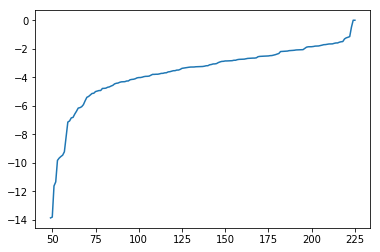

In [76]:
por_g = ADJ_bipartite_g.sum()/ADJ_bipartite_all.sum()
print sorted(por_g)
plt.plot(sorted(np.log(por_g)))
plt.show()


In [77]:
""" generate some country nodes"""
nodes = []

#Transpose countries to index, companies to columns
ADJ_bipartite_g = ADJ_bipartite_g.T
ADJ_bipartite_b = ADJ_bipartite_b.T
ADJ_bipartite_all = ADJ_bipartite_all.T
    
print 'Generating country nodes ...'
for j in ADJ_bipartite_all.index.values:
    #g and b just get portion of green and blue for the node properties
    g = int(ADJ_bipartite_g.loc[ADJ_bipartite_g.index==j].sum(axis=1)/ADJ_bipartite_all.loc[ADJ_bipartite_all.index==j].sum(axis=1)*255.0)
    b = int(ADJ_bipartite_b.loc[ADJ_bipartite_b.index==j].sum(axis=1)/ADJ_bipartite_all.loc[ADJ_bipartite_all.index==j].sum(axis=1)*255.0)

    #set country position to actual country centroid, set color to RGB with g and b, set size to f(total_MW)
    nodes.append(
            (j,{
                'type': 'country',
                'pos':np.array([df_centroids.get_value(j,'longitude'),df_centroids.get_value(j,'latitude')]),
                'n_color':"#{0:02x}{1:02x}{2:02x}".format(clamp(0), clamp(g), clamp(b)),
                'n_alpha':1.0,
                'n_size':(math.exp(math.log(ADJ_bipartite_all.loc[ADJ_bipartite_all.index==j].sum(axis=1),2.0)/3))}
            ))
print (nodes)

Generating country nodes ...


/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:19: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


[('CN', {'n_alpha': 1.0, 'n_size': 824.213293551979, 'type': 'country', 'pos': array([ 104.195397,   35.86166 ]), 'n_color': '#000338'}), ('NL', {'n_alpha': 1.0, 'n_size': 164.33370516659429, 'type': 'country', 'pos': array([  5.291266,  52.132633]), 'n_color': '#002b0a'}), ('KR', {'n_alpha': 1.0, 'n_size': 252.1779188227975, 'type': 'country', 'pos': array([ 127.766922,   35.907757]), 'n_color': '#001157'}), ('MY', {'n_alpha': 1.0, 'n_size': 157.1826151571657, 'type': 'country', 'pos': array([ 101.975766,    4.210484]), 'n_color': '#00182d'}), ('DE', {'n_alpha': 1.0, 'n_size': 388.7034571015535, 'type': 'country', 'pos': array([ 10.451526,  51.165691]), 'n_color': '#001e2f'}), ('JP', {'n_alpha': 1.0, 'n_size': 470.1618298826725, 'type': 'country', 'pos': array([ 138.252924,   36.204824]), 'n_color': '#000462'}), ('US', {'n_alpha': 1.0, 'n_size': 1041.445013274963, 'type': 'country', 'pos': array([-95.712891,  37.09024 ]), 'n_color': '#00233b'}), ('RU', {'n_alpha': 1.0, 'n_size': 437.4

In [78]:
""" generate some country-country edges """
edges=[]

#Adjacency matrices in MW
ADJ_bipartite_g_reduced = ADJ_bipartite_g.loc[(ADJ_bipartite_g != 0.0).any(axis=1), (ADJ_bipartite_g != 0.0).any(axis=0)] #MW
ADJ_bipartite_b_reduced = ADJ_bipartite_b.loc[(ADJ_bipartite_b != 0.0).any(axis=1), (ADJ_bipartite_b != 0.0).any(axis=0)] #MW
#ADJ_country_all =ADJ_bipartite_all.dot(ADJ_bipartite_all.T>0.0) #MW

#print ADJ_country_g.sum(axis=1)

#indices = list(ADJ_ISO.index)

#adjacency matrices in edge algo

#Generage country-country adjacentcy matrices, normalise
#drop sum==0 columns


ADJ_country_g =  (ADJ_bipartite_g_reduced/ADJ_bipartite_g_reduced.sum()).dot(ADJ_bipartite_g_reduced.T/(ADJ_bipartite_g_reduced.T.sum()))
ADJ_country_b = (ADJ_bipartite_b_reduced/ADJ_bipartite_b_reduced.sum()).dot(ADJ_bipartite_b_reduced.T/(ADJ_bipartite_b_reduced.T.sum()))
ADJ_country_all = (ADJ_bipartite_all/ADJ_bipartite_all.sum()).dot(ADJ_bipartite_all.T/(ADJ_bipartite_all.T.sum()))

ADJ_country_g.to_csv('./matrix_csvs/'+str(DATE)+'_green_projection.csv', encoding='utf-8')
ADJ_country_b.to_csv('./matrix_csvs/'+str(DATE)+'_blue_projection.csv', encoding='utf-8')
ADJ_country_all.to_csv('./matrix_csvs/'+str(DATE)+'_all_projection.csv', encoding='utf-8')


print ADJ_country_g

#for k1,k2s in ADJ_ISO.to_dict(orient='index').items():
#    for k2,v in k2s.items():
#        if v>0.0:
#            print (k1,k2,v)
#print ADJ_blue
#print ADJ_green

#df_ISO_pairs =  [ (k1,k2,v) for k2,v in k2s.items() for k1,k2s in ADJ_ISO.to_dict(orient='index').items()]

df_all_pairs =  [ {k:v for k,v in m.items() if v>0.0} for m in ADJ_country_all.to_dict(orient='rows')]
df_all_pairs = dict(zip(ADJ_country_all.index.values,df_all_pairs))


df_green_pairs =  [ {k:v for k,v in m.items() if v>0.0} for m in ADJ_country_g.to_dict(orient='rows')]
df_green_pairs = dict(zip(ADJ_country_g.index.values,df_green_pairs))

df_blue_pairs =  [ {k:v for k,v in m.items() if v>0.0} for m in ADJ_country_b.to_dict(orient='rows')]
df_blue_pairs = dict(zip(ADJ_country_b.index.values,df_blue_pairs))

    #print df_ISO_pairs

for k,v in df_all_pairs.items():
    v.pop(k,None)

    for k2,v2 in v.items():

        try:
            g = int(df_green_pairs[k][k2] / float(v2) * 255)
        except:
            g = 0

        try:
            b = int(df_blue_pairs[k][k2] / float(v2) * 255)
        except:
            b = 0

        edges.append(
            (k,k2,{
                'weight':np.log10(v2),
                'type':'country',
                'e_color': "#{0:02x}{1:02x}{2:02x}".format(clamp(0), clamp(g), clamp(b)),
            })) 
        
#print edges


          CN        NL        KR   MY        DE        JP            US   RU  \
CN  0.993085  0.000000  0.008726  0.0  0.000000  0.000000  0.000000e+00  0.0   
NL  0.000000  0.932434  0.000000  0.0  0.004462  0.000000  0.000000e+00  0.0   
KR  0.003899  0.000000  0.990279  0.0  0.000000  0.000656  0.000000e+00  0.0   
MY  0.000000  0.000000  0.000000  1.0  0.000000  0.000000  0.000000e+00  0.0   
DE  0.000000  0.019093  0.000000  0.0  0.963467  0.000000  1.723317e-07  0.0   
JP  0.000000  0.000000  0.000613  0.0  0.000000  0.965225  0.000000e+00  0.0   
US  0.000000  0.000000  0.000000  0.0  0.000002  0.000000  9.913945e-01  0.0   
RU  0.000000  0.000000  0.000000  0.0  0.000000  0.000000  0.000000e+00  1.0   
ZA  0.000000  0.000000  0.000000  0.0  0.000000  0.000000  0.000000e+00  0.0   
IN  0.000000  0.000000  0.000038  0.0  0.000000  0.000000  0.000000e+00  0.0   
PL  0.000000  0.000000  0.000000  0.0  0.001482  0.000000  0.000000e+00  0.0   
TW  0.000963  0.000000  0.000040  0.0  0

In [79]:
""" prep data for analysis """
m = len(ADJ_country_all)
print m
#print ADJ_country_g
#ADJ_country_g.values[[np.arange(m)]*2]=0
#ADJ_country_b.values[[np.arange(m)]*2]=0
ADJ_country_all.values[[np.arange(m)]*2]=0
POR_GREEN = ADJ_bipartite_g.T.sum()/ADJ_bipartite_all.T.sum()
#print ADJ_I_algo
print POR_GREEN
INFLUENCE = ADJ_country_all.T.dot(POR_GREEN) #transpose for inbound influence = general connection * green por
COUNTRY_1HOT = pd.get_dummies(INFLUENCE.index).set_index(INFLUENCE.index)
#print COUNTRY_1HOT
print INFLUENCE
DATA_OUT = POR_GREEN.to_frame(name='POR_GREEN').join(INFLUENCE.to_frame(name='INFLUENCE'))
DATA_OUT = DATA_OUT.join(COUNTRY_1HOT)
DATA_OUT['DATE']=DATE
print DATA_OUT
DATA_OUT.to_csv('./matrix_csvs/'+str(DATE)+'_por_green_influence.csv', encoding='utf-8')
#pickle.dump(DATA_OUT,open('data_pickles/data_'+str(DATE)+'.pickle','wb'))



226
CN    0.013436
NL    0.169037
KR    0.070457
MY    0.097310
DE    0.120728
JP    0.018013
US    0.138538
RU    0.012922
ZA    0.005904
IN    0.023305
PL    0.017608
TW    0.081088
ID    0.069435
TR    0.065457
LA    0.000012
PK    0.037684
VN    0.071790
TH    0.125521
SI    0.008405
MX    0.115338
AU    0.068890
IT    0.126294
BE    0.111471
PH    0.081343
CA    0.112412
FR    0.044968
BR    0.047957
IL    0.034332
CL    0.058785
MA    0.051430
        ...   
GI    0.000000
AI    0.000000
TO    0.010423
VU    0.190767
SB    0.120157
SO    0.025051
CK    0.005993
NP    0.000860
MS    0.013507
SZ    0.080199
IS    0.303147
FM    0.002120
SH    0.118730
DM    0.614622
BT    0.000000
KI    0.001394
NR    0.002334
KM    0.000000
BI    0.000000
TV    0.007240
FK    0.060525
CF    0.000000
WF    0.000000
LS    0.000000
NU    0.000000
LI    0.013340
MC    1.000000
AD    0.291536
TK    1.000000
GS    0.000000
Length: 226, dtype: float64
CN    0.000080
NL    0.008906
KR    0.000138
MY    0.

In [ ]:
""" show the country-projection graph """
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

pos = nx.get_node_attributes(G,'pos')
xs = [pos[k][0] for k,v in pos.iteritems()]
ys = [pos[k][1] for k,v in pos.iteritems()]


n_sizes = nx.get_node_attributes(G,'n_size')
n_colors = nx.get_node_attributes(G,'n_color')
n_alphas = nx.get_node_attributes(G,'n_alpha')
n_type = nx.get_node_attributes(G,'type')

fixed_nodes = [k for k in G.nodes() if n_type[k]=='country']
company_nodes = [k for k in G.nodes() if n_type[k]=='company']

n_cou_sizes = [n_sizes[k] for k in fixed_nodes]
n_cou_colors = [n_colors[k] for k in fixed_nodes]
n_cou_alphas = [n_alphas[k] for k in fixed_nodes]

n_com_sizes = [n_sizes[k] for k in company_nodes]
n_com_colors = [n_colors[k] for k in company_nodes]
n_com_alphas = [n_alphas[k] for k in company_nodes]





e_colors = nx.get_edge_attributes(G,'e_color')

e_colors = [G[u][v]['e_color'] for u,v in G.edges()]
e_colors_d = dict([((u,v),G[u][v]['e_color']) for u,v in G.edges()])
e_type = [((u,v),G[u][v]['type']) for u,v in G.edges()]

e_anchors = [l[0] for l in e_type if l[1]=='country']
e_anchors_colors = [e_colors_d[l] for l in e_anchors]
e_companies = [l[0] for l in e_type if l[1]=='company']
e_companies_colors = [e_colors_d[l] for l in e_companies]
    
fig, ax = plt.subplots(figsize=(16,9 ), dpi=100)

x_min = min(xs)-10
x_max = max(xs)+10
y_min = min(ys)-10
y_max = max(ys)+10

y_lim = [y_min,y_max]
x_lim = [x_min,x_max]
ax.set_ylim(y_lim)
ax.set_xlim(x_lim)
    
ax.set_position([0,0,1,1])

#print e_anchors_colors
#print e_anchors
nx.draw_networkx_edges(G, pos, edgelist =e_anchors,  alpha=0.2, ax=ax, edge_color=e_anchors_colors)#, nodelist=[ncenter], alpha=0.4)
#nx.draw_networkx_edges(G, pos, edgelist =e_companies,  alpha=0.2, ax=ax, edge_color=e_companies_colors)#, nodelist=[ncenter], alpha=0.4)
nodes_ax = nx.draw_networkx_nodes(G, pos,ax=ax, nodelist=fixed_nodes, node_size = n_cou_sizes, node_color = n_cou_colors,alpha= n_cou_alphas)#, nodelist=list(p.keys()),
                           #node_size=80,
                           #node_color=list(p.values()),
                           #cmap=plt.cm.Reds_r)
#nodes_ax = nx.draw_networkx_nodes(G, pos,ax=ax, nodelist=company_nodes, node_size = n_com_sizes, node_color = n_com_colors,alpha= n_com_alphas)#, nodelist=list(p.keys()),
                           

nodes_ax.set_edgecolor('w')

print 'Generating graphic: '
plt.axis('off')
plt.show()
plt.savefig('output.png')   

In [ ]:
def generate_network_graph(nodes, edges, spring_iters=0):

    print '~~~~~~~ GENEARTING GRAPHIC ~~~~~~'

    print 'Getting graph attributes...'

    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    pos = nx.get_node_attributes(G,'pos')
    
    pos_prev = pickle.load( open('pos_2017_Q3.pickle','rb'))

    for k,v in pos.items():
        if k in pos_prev.keys():
            pos[k] = pos_prev[k]


    #pos = nx.kamada_kawai_layout(G, k=10, weight='weight', pos=pos, center=[50,50])


    #for n in G:
    #	print n
    #	print n[1]['type'], n_alpha(n), n_color(n), n_size(n)

    #print G.nodes()
    #print pos

    n_sizes = nx.get_node_attributes(G,'n_size')
    n_colors = nx.get_node_attributes(G,'n_color')
    n_alphas = nx.get_node_attributes(G,'n_alpha')
    n_type = nx.get_node_attributes(G,'type')

    fixed_nodes = [k for k in G.nodes() if n_type[k]=='country']
    company_nodes = [k for k in G.nodes() if n_type[k]=='company']

    n_cou_sizes = [n_sizes[k] for k in fixed_nodes]
    n_cou_colors = [n_colors[k] for k in fixed_nodes]
    n_cou_alphas = [n_alphas[k] for k in fixed_nodes]

    n_com_sizes = [n_sizes[k] for k in company_nodes]
    n_com_colors = [n_colors[k] for k in company_nodes]
    n_com_alphas = [n_alphas[k] for k in company_nodes]





    e_colors = nx.get_edge_attributes(G,'e_color')

    e_colors = [G[u][v]['e_color'] for u,v in G.edges()]
    e_colors_d = dict([((u,v),G[u][v]['e_color']) for u,v in G.edges()])
    e_type = [((u,v),G[u][v]['type']) for u,v in G.edges()]

    e_anchors = [l[0] for l in e_type if l[1]=='anchor']
    e_anchors_colors = [e_colors_d[l] for l in e_anchors]
    e_companies = [l[0] for l in e_type if l[1]=='company']
    e_companies_colors = [e_colors_d[l] for l in e_companies]

    #print G.edges()
    #print e_colors
    #print len(e_colors)
    #print len(G.edges())
    #print e_type
    #print fixed_nodes

    #raw_input('-->')
    #print n_sizes
    #print n_colors
    #print n_alphas
    print 'Getting graph attributes: '
    print 'Generating force layout...'

    pos = nx.spring_layout(G, k=50, iterations=spring_iters, pos=pos, fixed=fixed_nodes, center=[0,0])
    pickle.dump(pos,open('pos_2017_Q4.pickle','wb'))

    print 'Generating force layout: '
    print 'Generating graphic...'

    fig, ax = plt.subplots(figsize=(16,9 ), dpi=100)

    xs = [pos[k][0] for k,v in pos.iteritems()]
    ys = [pos[k][1] for k,v in pos.iteritems()]

    x_min = min(xs)-10
    x_max = max(xs)+10
    y_min = min(ys)-10
    y_max = max(ys)+10

    y_lim = [y_min,y_max]
    x_lim = [x_min,x_max]
    ax.set_ylim(y_lim)
    ax.set_xlim(x_lim)
    
    ax.set_position([0,0,1,1])
    #nx.draw_networkx_edges(G, pos, edgelist =e_anchors,  alpha=0.2, ax=ax, edge_color=e_anchors_colors)#, nodelist=[ncenter], alpha=0.4)
    nx.draw_networkx_edges(G, pos, edgelist =e_companies,  alpha=0.2, ax=ax, edge_color=e_companies_colors)#, nodelist=[ncenter], alpha=0.4)
    #nodes_ax = nx.draw_networkx_nodes(G, pos,ax=ax, nodelist=fixed_nodes, node_size = n_cou_sizes, node_color = n_cou_colors,alpha= n_cou_alphas)#, nodelist=list(p.keys()),
                           #node_size=80,
                           #node_color=list(p.values()),
                           #cmap=plt.cm.Reds_r)
    nodes_ax = nx.draw_networkx_nodes(G, pos,ax=ax, nodelist=company_nodes, node_size = n_com_sizes, node_color = n_com_colors,alpha= n_com_alphas)#, nodelist=list(p.keys()),
                           #node_size=80,
                           #node_color=list(p.values()),
                           #cmap=plt.cm.Reds_r)

    nodes_ax.set_edgecolor('w')

    
    """
    for k,v in n_type.iteritems():
    	if v == 'country':
            try:
    		    #print k,pos[k]
    		    im = Image.open(os.path.join('flags_round','ISO', k+'.png'))
    		    im.thumbnail((16,16), Image.ANTIALIAS)
    		    im = np.array(im).astype(np.float)/255
    		    #print im.shape
    		    #print (pos[k][0] - x_lim[0])/103.*16*100-8, (pos[k][1]-y_lim[0])/float(y_lim[1]-y_lim[0])*9*100-8
    		    fig.figimage(im, xo=(pos[k][0] - x_lim[0])/float(x_lim[1]-x_lim[0])*16*100-8,yo=(pos[k][1]-y_lim[0])/float(y_lim[1]-y_lim[0])*9*100-8, zorder=3)  #offset in pixels.... pix per inch.
    		    #fig.figimage(im, xo= -pos[k][0],yo=pos[k][1])
            except:
                print 'broken country', k
                pass
    """
    
    
    



    #plt.xlim(-0.05, 1.05)
    #plt.ylim(-0.05, 1.05)
    print 'Generating graphic: '
    plt.axis('off')
    #plt.show()
    plt.savefig('output.png')   


    """
    G = nx.random_geometric_graph(200, 0.125)
    # position is stored as node attribute data for random_geometric_graph
    pos = nx.get_node_attributes(G, 'pos')
    
    # find node near center (0.5,0.5)
    dmin = 1
    ncenter = 0
    for n in pos:
        x, y = pos[n]
        d = (x - 0.5)**2 + (y - 0.5)**2
        if d < dmin:
            ncenter = n
            dmin = d
    
    
    pos = nx.spring_layout(G, iterations=50, pos=pos, center=[0.5,0.5])
    
    # color by path length from node near center
    p = dict(nx.single_source_shortest_path_length(G, ncenter))
    
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_edges(G, pos, nodelist=[ncenter], alpha=0.4)
    nx.draw_networkx_nodes(G, pos, nodelist=list(p.keys()),
                           node_size=80,
                           node_color=list(p.values()),
                           cmap=plt.cm.Reds_r)
    
    #plt.xlim(-0.05, 1.05)
    #plt.ylim(-0.05, 1.05)
    plt.axis('off')
    plt.show() 
    """

In [ ]:
company_subset_df = calculate_CCCE(wepp_df)

In [ ]:
nodes, edges, ADJ_green, ADJ_blue, ADJ_ISO = gen_country_projection(company_subset_df)

In [ ]:
generate_network_graph(nodes, edges)

In [ ]:
print ADJ_green